# Better image tiles - Simple heuristic to suppress blank regions

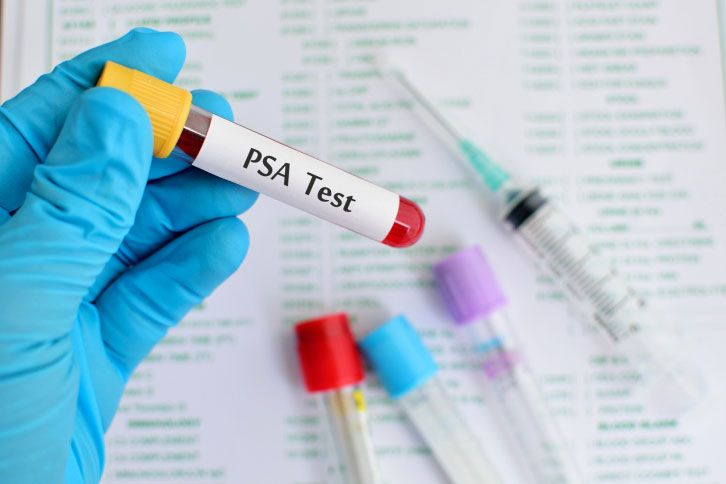

As you might know, for this competition, it is critical to come up with an efficient way to pre-process the images. One of the key aspects that I show in my previous notebook https://www.kaggle.com/rftexas/gradcam-comparing-resnet-and-se-resnext is that as expected white regions don't convey any information, hence the need to get rid of them. 

Actually, one need to zoom enough in the biopsy image to make sure there is **as little white as possible**.

This is why in this notebook, we will code a **simple heuristic** to generate better images that have no more blank parts.

The algorithm is pretty simple actually: having a **sliding window moving across the images** and calculating for each region the proporition of white color in the image. Then **select k regions** with the lowest proportion of white.

We will define the algorithm as follows:
- Define a sliding window of a fixed size
- Slide the window with a certain stride
- For each region on which we slide, compute the amount of white pixels
- Do this for all the regions in the image
- Select the top k results where k is a hyperparameter


** If you like those kinds of tutorials, upvote this notebook! It encourages me to keep writing some ;) **

V5: I'll try to tackle pen markers now! Stay tuned! 

# Contents

- <a href='#1'>1. Importing dependencies</a>
- <a href='#2'>2. Compute statistics</a>
- <a href='#3'>3. Select k-best regions</a>
- <a href='#4'>4. Slide over the image</a>
- <a href='#5'>5. Show the results</a>

    - <a href='#5.1.'>5.1. Window size: 200, stride: 128</a>
    - <a href='#5.2.'>5.2. Window size: 128, stride: 64</a>
    - <a href='#5.3.'>5.3. Window size: 512, stride: 256</a>

## Importing dependencies

In [1]:
import os
import time
import gc
import cv2
import PIL
import random
import openslide
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display

from torch import cuda

from multiprocessing import Pool

import cupy as cp



In [2]:
# cuda.set_device(0)
# print(cuda.get_device_name(0))

In [3]:
# train_df = pd.read_csv('/home/terry/Downloads/fai_data/train.csv').sample(n=10, random_state=0).reset_index(drop=True)
train_df = pd.read_csv('/home/terry/Downloads/fai_data/train.csv')
images = list(train_df['image_id'])
labels = list(train_df['isup_grade'])

In [4]:
data_dir = '/home/terry/Downloads/fai_data/train_images/'

In [5]:
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx,:z]

In [6]:
def slur(image, n):

    r1, g1, b1 = 214, 214, 214 
    r2, g2, b2 = 255, 255, 255
    red, green, blue = image[n:,:,0], image[n:,:,1], image[n:,:,2]
    mask =(red >= r1) & (green >= g1) & (blue >= b1)
    image[n:,:,:3][mask] = [r2, g2, b2]
#     slurred = np.copy(image)
    slurred = cp.copy(image)
    cp.cuda.Stream.null.synchronize()

    
    if n >= 0:
        slurred[n:,:,:3][mask] = image[:-n,:,:3][mask]
        
        
    del image
    del mask
    del red
    del green
    del blue
    print('.', end='')
    return slurred

In [7]:


def striplicate(npimage):
    image = cp.copy(npimage)
    cp.cuda.Stream.null.synchronize()
    # rimage = np.rot90(image, k=1)
    rimage = cp.rot90(image, k=1)
    cp.cuda.Stream.null.synchronize()

        
    r1, g1, b1 = 214, 214, 214 # Original value
    r2, g2, b2 = 255, 255, 255 # Value that we want to replace it with
    
   
    red, green, blue = image[:,:,0], image[:,:,1], image[:,:,2]
    rred, rgreen, rblue = rimage[:,:,0], rimage[:,:,1], rimage[:,:,2]
    
    mask = (red >= r1) & (green >= g1) & (blue >= b1)
    rmask =(rred >= r1) & (rgreen >= g1) & (rblue >= b1)
        
    rimage[:,:,:3][rmask] = [r2, g2, b2]
    del rmask
    rows,cols,depth = rimage.shape

    stripe_size = cols//3
    simage = None
    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage
            
    stripe_size = cols//24
    
    # simage = np.rot90(simage, k=1)
    simage = cp.rot90(simage, k=1)
    cp.cuda.Stream.null.synchronize()

    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage
            
    stripe_size = cols//12      
    # simage = np.rot90(simage, k=1)
    simage = cp.rot90(simage, k=1)
    cp.cuda.Stream.null.synchronize()

    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage
    
    stripe_size = cols//6
    # simage = np.rot90(simage, k=1)
    simage = cp.rot90(simage, k=1)
    cp.cuda.Stream.null.synchronize()
    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage

    stripe_size = cols//4
    # simage = np.rot90(simage, k=1)
    simage = cp.rot90(simage, k=1)
    cp.cuda.Stream.null.synchronize()

    for stripe in range(stripe_size, cols, stripe_size):
        # print(f'stripe: {stripe}, cols: {cols}')
        if simage is not None:
            simage = slur(simage, stripe_size)
        else:
            simage = slur(rimage, stripe_size)
            del rimage

            
    print(f'simage shape: {simage.shape}')


    image[:,:,:3][mask] = [r2, g2, b2]
    image[:,:,:3][mask] = simage[:,:,:3][mask]

#     return image
    return crop_center(image, 2048, 2048)

In [8]:
def process_images(range_list):
    starting_index, ending_index = range_list
    import imageio

    for counter, img in enumerate(images):
    #     if counter > 0:
    #         continue

        if counter < starting_index or counter > ending_index or os.path.isfile(f'/home/terry/Downloads/fai_data/slur4/{img}.jpeg'):
            continue
        print(f'{counter}', end=', ')
        url = data_dir + img + '.tiff'
        image = im = imageio.imread(url)
        print(f'original image shape: {image.shape}')
        file_size = os.path.getsize(url)
    #     rightsizer = min(3, 9000000/file_size)
        rightsizer = 5_000_000/file_size

        print(f'file_size: {file_size}, rightsizer: {rightsizer}')

        rows,cols,depth = image.shape
        rcmin = min(rows, cols)
        rcmax = max(rows, cols)
        timage = np.zeros([rcmax,rcmax,3],dtype=np.uint8)
        timage.fill(255) # or square_image[:] = 255
        

#         # I don't know if this is even possible:
#         # My GTX1060 isn't big enough to do cupy.full() on the big files:
#         if rcmax < 26000:
#             timage = cp.full([rcmax,rcmax,3], 255, dtype=np.uint8)
#             cp.cuda.Stream.null.synchronize()
#             print(f'Used cp.full() on smaller file: {img}.jpeg')
#         else:
#             timage = np.zeros([rcmax,rcmax,3],dtype=np.uint8)
#             timage.fill(255) # or square_image[:] = 255
                

        #G timage = image[:rcmin,:rcmin,:3].copy()
        timage[:rows,:cols,:3] = image[:rows,:cols,:3]
        print(f'timage shape: {timage.shape}')
        del image

        new_img = cv2.resize(timage,(int(timage.shape[1]*rightsizer), int(timage.shape[0]*rightsizer)))
        print(f'new_img shape: {new_img.shape}')
        del timage


        slurred_image = striplicate(new_img)
        del new_img

        # npImage = np.array(slurred_image, dtype=np.uint8)
        npImage = np.array(slurred_image, dtype=np.uint8)

        print(f'\nSaving file: /home/terry/Downloads/fai_data/slur4/{img}.jpeg')
        plt.imsave(f'/home/terry/Downloads/fai_data/slur4/{img}.jpeg', npImage, format='jpg')

        plt.close()

        del npImage
        del slurred_image
        gc.collect()
        

In [9]:
nprocs=7
end=10620
group_len = end//nprocs
start=0

range_list = list()

for i in range(1,nprocs+1):
    end = group_len * i
    range_list.append([start, end])
    start = end

with Pool(nprocs) as workers:
    w = list(workers.map(process_images, range_list))
    print(w)

6068, original image shape: (9216, 9728, 3)
file_size: 13988367, rightsizer: 0.3574398641385374
timage shape: (9728, 9728, 3)
new_img shape: (3477, 3477, 3)
10609, original image shape: (16640, 15360, 3)
file_size: 21300225, rightsizer: 0.2347393043970193
timage shape: (16640, 16640, 3)
new_img shape: (3906, 3906, 3)
6014, original image shape: (39680, 98304, 3)
file_size: 229545467, rightsizer: 0.02178217703597693
................................................simage shape: (3477, 3477, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9526ed25cd1ac4113139593575131cd1.jpeg
6069, original image shape: (26650, 30876, 3)
file_size: 48934083, rightsizer: 0.10217827112444305
timage shape: (30876, 30876, 3)
new_img shape: (3154, 3154, 3)
...............................................simage shape: (3906, 3906, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ffcd99c47e57ad2934dc6bbf5edf6675.jpeg
10610, original image shape: (17787, 38844, 3)
file_size: 55398209, rightsizer: 0.0902

timage shape: (24576, 24576, 3)
new_img shape: (3473, 3473, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/957b6739a057adf1eef9ff91f31afe43.jpeg
6081, original image shape: (41216, 19456, 3)
file_size: 56326235, rightsizer: 0.08876858181627087
timage shape: (41216, 41216, 3)
new_img shape: (3658, 3658, 3)
.................................................simage shape: (3473, 3473, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/93cb817e07cba6f15d4dffcf8344316a.jpeg
6020, original image shape: (28180, 24900, 3)
file_size: 47653995, rightsizer: 0.10492299753672278
timage shape: (28180, 28180, 3)
new_img shape: (2956, 2956, 3)
.................................................simage shape: (3658, 3658, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/957c6cf443a82d55f348284784fe6324.jpeg
6082, original image shape: (32531, 23904, 3)
file_size: 51697931, rightsizer: 0.09671566933694116
timage shape: (32531, 32531, 3)
new_img shape: (3146, 3146, 3)
..........................

...............................................simage shape: (2406, 2406, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/95c16154511d02d6cecdd6cb9b3a7ffd.jpeg
6092, original image shape: (32000, 20480, 3)
file_size: 41313931, rightsizer: 0.12102455222670531
timage shape: (32000, 32000, 3)
new_img shape: (3872, 3872, 3)
...............................................simage shape: (3966, 3966, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/94357950df8207565fbe7d59a3084a1c.jpeg
6034, original image shape: (8192, 26368, 3)
file_size: 25801697, rightsizer: 0.19378570332021183
timage shape: (26368, 26368, 3)
new_img shape: (5109, 5109, 3)
................................................simage shape: (3872, 3872, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/95c2d3c62a1958314c31967600e736ee.jpeg
6093, original image shape: (23040, 6912, 3)
file_size: 21609619, rightsizer: 0.23137844309055147
timage shape: (23040, 23040, 3)
new_img shape: (5330, 5330, 3)
.................

................................................simage shape: (2679, 2679, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9601e9f2ce0e61c627ec08bdd50d4f53.jpeg
6107, original image shape: (10240, 22016, 3)
file_size: 21559413, rightsizer: 0.23191726045602448
timage shape: (22016, 22016, 3)
new_img shape: (5105, 5105, 3)
.................................................simage shape: (6722, 6722, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/949247a2b70a0976687f44de498ed601.jpeg
6044, original image shape: (29952, 26624, 3)
file_size: 53958745, rightsizer: 0.09266338570328128
timage shape: (29952, 29952, 3)
new_img shape: (2775, 2775, 3)
................................................simage shape: (2775, 2775, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/949819ffbb671f6db1ebba07195d5571.jpeg
6045, original image shape: (29696, 14080, 3)
file_size: 41551363, rightsizer: 0.1203329960559898
timage shape: (29696, 29696, 3)
new_img shape: (3573, 3573, 3)
.............


Saving file: /home/terry/Downloads/fai_data/slur4/94f59c80441412249d37ee784bbb64aa.jpeg
6058, original image shape: (26972, 24900, 3)
file_size: 50684717, rightsizer: 0.09864906614749373
timage shape: (26972, 26972, 3)
new_img shape: (2660, 2660, 3)
................................................simage shape: (2660, 2660, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/94f6b16d7289691642d1a611c4f1997f.jpeg
6059, original image shape: (36608, 10496, 3)
file_size: 36236623, rightsizer: 0.13798195267809585
timage shape: (36608, 36608, 3)
new_img shape: (5051, 5051, 3)
.................................................simage shape: (9347, 9347, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/96415990a25ee1d758a8bc7ae97d593f.jpeg
6118, original image shape: (28160, 24576, 3)
file_size: 41892339, rightsizer: 0.11935356486063001
timage shape: (28160, 28160, 3)
new_img shape: (3360, 3360, 3)
............................................simage shape: (3360, 3360, 3)

Saving file: /h

timage shape: (36399, 36399, 3)
new_img shape: (3272, 3272, 3)
................................................simage shape: (3272, 3272, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/96a65a6ddc0ff8bac4231b50957ab64c.jpeg
6133, original image shape: (21760, 14080, 3)
file_size: 30371681, rightsizer: 0.16462704188154748
timage shape: (21760, 21760, 3)
new_img shape: (3582, 3582, 3)
...............................................simage shape: (3582, 3582, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/96aac9c3672cadf72e9e60d634bb145a.jpeg
6134, original image shape: (6144, 4864, 3)
file_size: 5286823, rightsizer: 0.9457475690031613
timage shape: (6144, 6144, 3)
new_img shape: (5810, 5810, 3)
.................................................simage shape: (5810, 5810, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/96b25c6d10a1c6c3814433b014afae0f.jpeg
6135, original image shape: (7680, 20736, 3)
file_size: 13994635, rightsizer: 0.35727977185542886
timage shape: (20736

new_img shape: (2918, 2918, 3)
.................................................simage shape: (2918, 2918, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9741cdc1c51f48c18871789cdb8491fd.jpeg
6158, original image shape: (26112, 7936, 3)
file_size: 29622995, rightsizer: 0.16878779475201613
timage shape: (26112, 26112, 3)
new_img shape: (4407, 4407, 3)
................................................simage shape: (4407, 4407, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/97425535f7cd9edbfdcebb3d9fdce17b.jpeg
6159, original image shape: (34816, 21504, 3)
file_size: 47558935, rightsizer: 0.10513271586085769
timage shape: (34816, 34816, 3)
new_img shape: (3660, 3660, 3)
.............................................simage shape: (3660, 3660, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9746a908fb142b961e5b0b1afef3dac4.jpeg
6160, original image shape: (6656, 29952, 3)
file_size: 23973359, rightsizer: 0.20856484900593195
timage shape: (29952, 29952, 3)
new_img shape: (6

new_img shape: (5213, 5213, 3)
.................................................simage shape: (5213, 5213, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/97a072070bccd353b385580daed8b3f5.jpeg
6183, original image shape: (26811, 21912, 3)
file_size: 39450661, rightsizer: 0.1267405887064858
timage shape: (26811, 26811, 3)
new_img shape: (3398, 3398, 3)
.................................................simage shape: (3398, 3398, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/97a08708adfb345f406e85397b0e05e3.jpeg
6184, original image shape: (23040, 4352, 3)
file_size: 19301467, rightsizer: 0.25904766720581396
timage shape: (23040, 23040, 3)
new_img shape: (5968, 5968, 3)
................................................simage shape: (5968, 5968, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/97a83309575b765469e6a09250d92170.jpeg
6185, original image shape: (22016, 14336, 3)
file_size: 26500121, rightsizer: 0.18867838377039864
timage shape: (22016, 22016, 3)
new_img shape

new_img shape: (2912, 2912, 3)
................................................simage shape: (2912, 2912, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/99b76caa997ed99703923c07cc44a7bf.jpeg
6283, original image shape: (21760, 5888, 3)
file_size: 12220647, rightsizer: 0.40914364026716427
timage shape: (21760, 21760, 3)
new_img shape: (8902, 8902, 3)
.................................................simage shape: (8902, 8902, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/99bc60c2d554be9304993efa0a5ef740.jpeg
6284, original image shape: (25344, 12800, 3)
file_size: 31000333, rightsizer: 0.1612885900290168
timage shape: (25344, 25344, 3)
new_img shape: (4087, 4087, 3)
.................................................simage shape: (4087, 4087, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/99c6eb1d87928dfae4d098276b85b98c.jpeg
6285, original image shape: (19968, 20480, 3)
file_size: 28596457, rightsizer: 0.17484683504673323
timage shape: (20480, 20480, 3)
new_img shape

new_img shape: (6826, 6826, 3)
.................................................simage shape: (6826, 6826, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9a3ad5844e796a97e725de8fa7518144.jpeg
6308, original image shape: (2304, 2304, 3)
file_size: 1195565, rightsizer: 4.1821230966112255
timage shape: (2304, 2304, 3)
new_img shape: (9635, 9635, 3)
.................................................simage shape: (9635, 9635, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9a4ba048c62623465d6a7a0d8549a657.jpeg
6309, original image shape: (39058, 21912, 3)
file_size: 53407929, rightsizer: 0.09361905794924195
timage shape: (39058, 39058, 3)
new_img shape: (3656, 3656, 3)
................................................simage shape: (3656, 3656, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9a4f94a859e0553fc06a21fb30fa86cd.jpeg
6310, original image shape: (17920, 18432, 3)
file_size: 32413259, rightsizer: 0.15425786095745572
timage shape: (18432, 18432, 3)
new_img shape: (2

new_img shape: (5580, 5580, 3)
.............................................simage shape: (5580, 5580, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9b238129762edd83f472e5b3abf9e639.jpeg
6333, original image shape: (19317, 32868, 3)
file_size: 50534911, rightsizer: 0.0989415020440028
timage shape: (32868, 32868, 3)
new_img shape: (3252, 3252, 3)
.............................................simage shape: (3252, 3252, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9b24d12545a72daf963173a390f5bf72.jpeg
6334, original image shape: (27392, 27648, 3)
file_size: 49356437, rightsizer: 0.10130390895112627
timage shape: (27648, 27648, 3)
new_img shape: (2800, 2800, 3)
................................................simage shape: (2800, 2800, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9b2948ff81b64677a1a152a1532c1a50.jpeg
6335, original image shape: (29147, 25896, 3)
file_size: 52606683, rightsizer: 0.09504495845138154
timage shape: (29147, 29147, 3)
new_img shape: (2770

new_img shape: (2744, 2744, 3)
................................................simage shape: (2744, 2744, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9ba7f932ed3494e9b53913a57ada7361.jpeg
6358, original image shape: (35996, 39839, 3)
file_size: 77730417, rightsizer: 0.06432488326931271
timage shape: (39839, 39839, 3)
new_img shape: (2562, 2562, 3)
...............................................simage shape: (2562, 2562, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9badca58cd4dbe1ba757e725456753d0.jpeg
6359, original image shape: (14080, 26112, 3)
file_size: 23665557, rightsizer: 0.21127751187094393
timage shape: (26112, 26112, 3)
new_img shape: (5516, 5516, 3)
................................................simage shape: (5516, 5516, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9bb08719f4422442cba4253b2ba34b62.jpeg
6360, original image shape: (10240, 18944, 3)
file_size: 17152073, rightsizer: 0.291509953344998
timage shape: (18944, 18944, 3)
new_img shape: (

new_img shape: (10359, 10359, 3)
................................................simage shape: (10359, 10359, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9c24ae764d87098d03faccc2e2a579d0.jpeg
6383, original image shape: (20736, 13568, 3)
file_size: 28181261, rightsizer: 0.17742286266040402
timage shape: (20736, 20736, 3)
new_img shape: (3679, 3679, 3)
.................................................simage shape: (3679, 3679, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9c28f2bb8ecc9e89f8c141b768434d67.jpeg
6384, original image shape: (29184, 27648, 3)
file_size: 44176009, rightsizer: 0.11318360606092778
timage shape: (29184, 29184, 3)
new_img shape: (3303, 3303, 3)
................................................simage shape: (3303, 3303, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9c2b708c21a6f7f2c4bebce9d6c74436.jpeg
6385, original image shape: (11520, 30208, 3)
file_size: 33066537, rightsizer: 0.1512102703709191
timage shape: (30208, 30208, 3)
new_img s

new_img shape: (5136, 5136, 3)
............................................simage shape: (5136, 5136, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9cb403f9210675606bac5259b8cdc3e3.jpeg
6408, original image shape: (24064, 3584, 3)
file_size: 17285105, rightsizer: 0.28926639438985186
timage shape: (24064, 24064, 3)
new_img shape: (6960, 6960, 3)
............................................simage shape: (6960, 6960, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9cc0b83fe973227ce03e633f5c6e5d8b.jpeg
6409, original image shape: (32000, 25600, 3)
file_size: 45293311, rightsizer: 0.11039157636322944
timage shape: (32000, 32000, 3)
new_img shape: (3532, 3532, 3)
................................................simage shape: (3532, 3532, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9cc2751013da725b91b353552f749d04.jpeg
6410, original image shape: (24576, 38912, 3)
file_size: 78523535, rightsizer: 0.06367517713001586
timage shape: (38912, 38912, 3)
new_img shape: (2477, 

new_img shape: (3284, 3284, 3)
................................................simage shape: (3284, 3284, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9d362cc6fa6cb21f94c2115d6704c72e.jpeg
6433, original image shape: (32256, 25600, 3)
file_size: 62812899, rightsizer: 0.07960148440211301
timage shape: (32256, 32256, 3)
new_img shape: (2567, 2567, 3)
.................................................simage shape: (2567, 2567, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9d36aeb4b4430baae6853ec391168e4c.jpeg
6434, original image shape: (16384, 5888, 3)
file_size: 17133727, rightsizer: 0.29182208867924647
timage shape: (16384, 16384, 3)
new_img shape: (4781, 4781, 3)
.................................................simage shape: (4781, 4781, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9d37a84912687a7594646ce21657db2c.jpeg
6435, original image shape: (14336, 22528, 3)
file_size: 24292569, rightsizer: 0.20582425843886665
timage shape: (22528, 22528, 3)
new_img shap

new_img shape: (8127, 8127, 3)
................................................simage shape: (8127, 8127, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9daae3ddf1e47ccd9d2013917e47f497.jpeg
6458, original image shape: (24832, 25600, 3)
file_size: 42099067, rightsizer: 0.1187674776735551
timage shape: (25600, 25600, 3)
new_img shape: (3040, 3040, 3)
................................................simage shape: (3040, 3040, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9dbc64b9e7a18cfdd825ea44219b8330.jpeg
6459, original image shape: (27904, 11264, 3)
file_size: 18118635, rightsizer: 0.27595897814598064
timage shape: (27904, 27904, 3)
new_img shape: (7700, 7700, 3)
................................................simage shape: (7700, 7700, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9dc28ee23b2f728632e3ac9c1421e23b.jpeg
6460, original image shape: (18176, 6400, 3)
file_size: 10579573, rightsizer: 0.47260886616123354
timage shape: (18176, 18176, 3)
new_img shape: 

new_img shape: (6101, 6101, 3)
.................................................simage shape: (6101, 6101, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9e3843c81ae2badfb22d9a46813d4470.jpeg
6483, original image shape: (17545, 22908, 3)
file_size: 26815543, rightsizer: 0.18645902490208757
timage shape: (22908, 22908, 3)
new_img shape: (4271, 4271, 3)
.................................................simage shape: (4271, 4271, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9e3b074837049467ea4802ae9815ed2d.jpeg
6484, original image shape: (29953, 15936, 3)
file_size: 36843897, rightsizer: 0.135707685861786
timage shape: (29953, 29953, 3)
new_img shape: (4064, 4064, 3)
................................................simage shape: (4064, 4064, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9e3e3e78c43a9efd53e894e069ebe753.jpeg
6485, original image shape: (2816, 2304, 3)
file_size: 1694467, rightsizer: 2.9507803928905076
timage shape: (2816, 2816, 3)
new_img shape: (830

new_img shape: (2749, 2749, 3)
.................................................simage shape: (2749, 2749, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9ed8ec7bf90653bc4ca86b3ca53cbb96.jpeg
6508, original image shape: (24576, 6144, 3)
file_size: 21179931, rightsizer: 0.23607253489163868
timage shape: (24576, 24576, 3)
new_img shape: (5801, 5801, 3)
.................................................simage shape: (5801, 5801, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9edf591d741baf346fc1ff0f42dd4ddc.jpeg
6509, original image shape: (37768, 25896, 3)
file_size: 66941253, rightsizer: 0.0746923574914261
timage shape: (37768, 37768, 3)
new_img shape: (2820, 2820, 3)
.............................................simage shape: (2820, 2820, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/9ef78f4a0c54b5ccb6f7d16a43d1fc78.jpeg
6510, original image shape: (12032, 7936, 3)
file_size: 12215371, rightsizer: 0.40932035547671863
timage shape: (12032, 12032, 3)
new_img shape: (4

new_img shape: (2907, 2907, 3)
................................................simage shape: (2907, 2907, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a11991dab102085728874c2f348eeffa.jpeg
6621, original image shape: (4096, 24832, 3)
file_size: 15347003, rightsizer: 0.32579650893402445
timage shape: (24832, 24832, 3)
new_img shape: (8090, 8090, 3)
.................................................simage shape: (8090, 8090, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a12ac7f1bc26fe59d642674fcbe45a30.jpeg
6622, original image shape: (28672, 4864, 3)
file_size: 18493651, rightsizer: 0.27036305594822785
timage shape: (28672, 28672, 3)
new_img shape: (7751, 7751, 3)
.................................................simage shape: (7751, 7751, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a12cf12bd480d36325d9141e5fce729d.jpeg
6623, original image shape: (22528, 20480, 3)
file_size: 23375483, rightsizer: 0.21389932349205362
timage shape: (22528, 22528, 3)
new_img shape

new_img shape: (4614, 4614, 3)
...............................................simage shape: (4614, 4614, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a27a666f057315f08ce43d8da423e8ea.jpeg
6678, original image shape: (20607, 20916, 3)
file_size: 30852069, rightsizer: 0.16206368525883952
timage shape: (20916, 20916, 3)
new_img shape: (3389, 3389, 3)
.................................................simage shape: (3389, 3389, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a27ab1c1998e93cfb6d34a3cdacd1b5a.jpeg
6679, original image shape: (25600, 5632, 3)
file_size: 19035975, rightsizer: 0.26266056768828494
timage shape: (25600, 25600, 3)
new_img shape: (6724, 6724, 3)
................................................simage shape: (6724, 6724, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a280d60407c69e37fad4d7290ac948a6.jpeg
6680, original image shape: (24832, 4608, 3)
file_size: 18682377, rightsizer: 0.26763189716169417
timage shape: (24832, 24832, 3)
new_img shape: 

new_img shape: (4085, 4085, 3)
.................................................simage shape: (4085, 4085, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a2ea42fa1f08d6f672e3c826a885f849.jpeg
6703, original image shape: (33536, 26624, 3)
file_size: 48985317, rightsizer: 0.10207140233470369
timage shape: (33536, 33536, 3)
new_img shape: (3423, 3423, 3)
................................................simage shape: (3423, 3423, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a2eb130a296ca0ff83e1b530108dac25.jpeg
6704, original image shape: (12800, 7424, 3)
file_size: 12824919, rightsizer: 0.38986601006992716
timage shape: (12800, 12800, 3)
new_img shape: (4990, 4990, 3)
.................................................simage shape: (4990, 4990, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a2f1af7bf2b86cdabfcffe65d8424a3a.jpeg
6705, original image shape: (27648, 7424, 3)
file_size: 17480371, rightsizer: 0.2860351190486747
timage shape: (27648, 27648, 3)
new_img shape:

new_img shape: (3031, 3031, 3)
.................................................simage shape: (3031, 3031, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a37fce1f9bf89a23e99ff436d8c3710f.jpeg
6728, original image shape: (25344, 21504, 3)
file_size: 43049333, rightsizer: 0.11614581810129324
timage shape: (25344, 25344, 3)
new_img shape: (2943, 2943, 3)
................................................simage shape: (2943, 2943, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a383c97bbe2095ea5d4a7c33a35b2c4e.jpeg
6729, original image shape: (32000, 27648, 3)
file_size: 53226241, rightsizer: 0.09393862700167009
timage shape: (32000, 32000, 3)
new_img shape: (3006, 3006, 3)
...............................................simage shape: (3006, 3006, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a38edfd7f0ab8eb00995e7c1c3168b60.jpeg
6730, original image shape: (23552, 10752, 3)
file_size: 21232213, rightsizer: 0.23549123211979833
timage shape: (23552, 23552, 3)
new_img shape

new_img shape: (4363, 4363, 3)
.................................................simage shape: (4363, 4363, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a43ae1d4fbbb8606f3e38d2f21824b61.jpeg
6753, original image shape: (28672, 6144, 3)
file_size: 27935729, rightsizer: 0.17898226317988694
timage shape: (28672, 28672, 3)
new_img shape: (5131, 5131, 3)
.................................................simage shape: (5131, 5131, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a43c01d2b679f67377e6909bd94128a5.jpeg
6754, original image shape: (20123, 19919, 3)
file_size: 30781829, rightsizer: 0.16243349282461417
timage shape: (20123, 20123, 3)
new_img shape: (3268, 3268, 3)
................................................simage shape: (3268, 3268, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a4400c5e31462e7d221bb1a06d2ba0de.jpeg
6755, original image shape: (23552, 17408, 3)
file_size: 30999855, rightsizer: 0.16129107700665052
timage shape: (23552, 23552, 3)
new_img shap

new_img shape: (7475, 7475, 3)
.................................................simage shape: (7475, 7475, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a4ef4e6aecb75b4af94a115045b0b0d7.jpeg
6778, original image shape: (32768, 15360, 3)
file_size: 44598889, rightsizer: 0.11211041602404041
timage shape: (32768, 32768, 3)
new_img shape: (3673, 3673, 3)
.................................................simage shape: (3673, 3673, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a4effa6d0c2e32e36e45f32f9e7e4977.jpeg
6779, original image shape: (9728, 40704, 3)
file_size: 45822407, rightsizer: 0.1091169217714818
timage shape: (40704, 40704, 3)
new_img shape: (4441, 4441, 3)
.................................................simage shape: (4441, 4441, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a4f80816b9e11c4ac2ce7ffc2a526cd5.jpeg
6780, original image shape: (23910, 39839, 3)
file_size: 62619297, rightsizer: 0.07984759075145798
timage shape: (39839, 39839, 3)
new_img shap

.................................................simage shape: (3629, 3629, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a59b754e6ae29ba224e7422995ebb5fe.jpeg
6803, original image shape: (19200, 4864, 3)
file_size: 17309685, rightsizer: 0.28885563197712727
timage shape: (19200, 19200, 3)
new_img shape: (5546, 5546, 3)
.................................................simage shape: (5546, 5546, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a5a27468f2a7a299cb8b952abb941705.jpeg
6804, original image shape: (22784, 9728, 3)
file_size: 18116017, rightsizer: 0.2759988578063269
timage shape: (22784, 22784, 3)
new_img shape: (6288, 6288, 3)
............................................simage shape: (6288, 6288, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a5a7c62ef1e0d28a54c2da8355447c22.jpeg
6805, original image shape: (30720, 23552, 3)
file_size: 43491881, rightsizer: 0.11496398603684214
timage shape: (30720, 30720, 3)
new_img shape: (3531, 3531, 3)
..................

...............................................simage shape: (3714, 3714, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a6186d1386a1b5bb55de5711b293bc26.jpeg
6828, original image shape: (28672, 11264, 3)
file_size: 28909747, rightsizer: 0.17295204970143807
timage shape: (28672, 28672, 3)
new_img shape: (4958, 4958, 3)
.................................................simage shape: (4958, 4958, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a61bde5fa031a829eed61c44ea348963.jpeg
6829, original image shape: (40448, 28672, 3)
file_size: 61086055, rightsizer: 0.0818517417764169
timage shape: (40448, 40448, 3)
new_img shape: (3310, 3310, 3)
.................................................simage shape: (3310, 3310, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a6220c7ef591dd3f61c996877d0504d8.jpeg
6830, original image shape: (3072, 17152, 3)
file_size: 9007739, rightsizer: 0.5550782499359718
timage shape: (17152, 17152, 3)
new_img shape: (9520, 9520, 3)
................

................................................simage shape: (4065, 4065, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a6c30b9c00539ff6e70c8fc774232c61.jpeg
6853, original image shape: (11520, 15104, 3)
file_size: 19988007, rightsizer: 0.2501500024489685
timage shape: (15104, 15104, 3)
new_img shape: (3778, 3778, 3)
.................................................simage shape: (3778, 3778, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a6da01c66cfebf7492f28f70bae9b5de.jpeg
6854, original image shape: (37527, 25896, 3)
file_size: 60729481, rightsizer: 0.0823323354270062
timage shape: (37527, 37527, 3)
new_img shape: (3089, 3089, 3)
.................................................simage shape: (3089, 3089, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a6dc33bb603930579b430c76162a7a4c.jpeg
6855, original image shape: (31488, 7168, 3)
file_size: 27403695, rightsizer: 0.18245714674608662
timage shape: (31488, 31488, 3)
new_img shape: (5745, 5745, 3)
..............

................................................simage shape: (5037, 5037, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a766e096ab436d7ae7a55eb46a4fcf5e.jpeg
6878, original image shape: (28928, 29696, 3)
file_size: 50974839, rightsizer: 0.09808760749592559
timage shape: (29696, 29696, 3)
new_img shape: (2912, 2912, 3)
................................................simage shape: (2912, 2912, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a76cb105593aaea1617759e233fb226e.jpeg
6879, original image shape: (28160, 22528, 3)
file_size: 43732801, rightsizer: 0.1143306599547557
timage shape: (28160, 28160, 3)
new_img shape: (3219, 3219, 3)
................................................simage shape: (3219, 3219, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a778e005ed493fbc8905dfe811694b17.jpeg
6880, original image shape: (24576, 7680, 3)
file_size: 22610853, rightsizer: 0.22113274541212577
timage shape: (24576, 24576, 3)
new_img shape: (5434, 5434, 3)
...............

.................................................simage shape: (3125, 3125, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a807e60ff7d13f837e27c6fb39eb6986.jpeg
6903, original image shape: (20224, 6912, 3)
file_size: 16876911, rightsizer: 0.29626274618619486
timage shape: (20224, 20224, 3)
new_img shape: (5991, 5991, 3)
................................................simage shape: (5991, 5991, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a807e743ad2020d229347aede1882a8f.jpeg
6904, original image shape: (3072, 16896, 3)
file_size: 11142733, rightsizer: 0.44872294795181755
timage shape: (16896, 16896, 3)
new_img shape: (7581, 7581, 3)
................................................simage shape: (7581, 7581, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a80ae4f5811fa7a1042d78be4aedf45c.jpeg
6905, original image shape: (10240, 26368, 3)
file_size: 23595817, rightsizer: 0.2119019655051571
timage shape: (26368, 26368, 3)
new_img shape: (5587, 5587, 3)
...............

.................................................simage shape: (2974, 2974, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a8a381e648b69bc0023ea882eb436bdb.jpeg
6928, original image shape: (13056, 27904, 3)
file_size: 30885415, rightsizer: 0.16188871025369095
timage shape: (27904, 27904, 3)
new_img shape: (4517, 4517, 3)
.................................................simage shape: (4517, 4517, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a8a951c084f704fb77c2a3ab1c21b474.jpeg
6929, original image shape: (25344, 8960, 3)
file_size: 23718249, rightsizer: 0.21080814186578445
timage shape: (25344, 25344, 3)
new_img shape: (5342, 5342, 3)
.................................................simage shape: (5342, 5342, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a8b8f6be7310d77eb7e785e2f341a137.jpeg
6930, original image shape: (5632, 16128, 3)
file_size: 9502067, rightsizer: 0.5262012991489114
timage shape: (16128, 16128, 3)
new_img shape: (8486, 8486, 3)
..............

.................................................simage shape: (6698, 6698, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a94d63bd5c038c48f6a280233c3c7dd5.jpeg
6953, original image shape: (12544, 10752, 3)
file_size: 14225139, rightsizer: 0.35149041425886945
timage shape: (12544, 12544, 3)
new_img shape: (4409, 4409, 3)
.................................................simage shape: (4409, 4409, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a9534d1d06ad290d690bd88a164b9657.jpeg
6954, original image shape: (31232, 23552, 3)
file_size: 44580125, rightsizer: 0.11215760386495104
timage shape: (31232, 31232, 3)
new_img shape: (3502, 3502, 3)
.................................................simage shape: (3502, 3502, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a954a0cc5ddb665162f367e46e4c5a39.jpeg
6955, original image shape: (6144, 20480, 3)
file_size: 19406321, rightsizer: 0.2576480106662154
timage shape: (20480, 20480, 3)
new_img shape: (5276, 5276, 3)
............

new_img shape: (3397, 3397, 3)
.................................................simage shape: (3397, 3397, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a9f1aee928c544e2fd4a4cd448771a38.jpeg
6978, original image shape: (32768, 9984, 3)
file_size: 38328223, rightsizer: 0.13045217358498462
timage shape: (32768, 32768, 3)
new_img shape: (4274, 4274, 3)
.................................................simage shape: (4274, 4274, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/a9ff261ddbae34cbbb6b5d5c0f2d1ce6.jpeg
6979, original image shape: (32512, 21504, 3)
file_size: 47410311, rightsizer: 0.10546229068187297
timage shape: (32512, 32512, 3)
new_img shape: (3428, 3428, 3)
................................................simage shape: (3428, 3428, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/aa01c9186774a385e42095c28d3f12bd.jpeg
6980, original image shape: (34304, 29696, 3)
file_size: 61228805, rightsizer: 0.08166091106955296
timage shape: (34304, 34304, 3)
new_img shap

new_img shape: (4532, 4532, 3)
................................................simage shape: (4532, 4532, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/aa9be7d9f82e983d21e2746078b877d9.jpeg
7003, original image shape: (28160, 28672, 3)
file_size: 52561835, rightsizer: 0.09512605486471315
timage shape: (28672, 28672, 3)
new_img shape: (2727, 2727, 3)
................................................simage shape: (2727, 2727, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/aaa5732cd49bffddf0d2b7d36fbb0a83.jpeg
7004, original image shape: (27052, 20916, 3)
file_size: 46335551, rightsizer: 0.10790850420662959
timage shape: (27052, 27052, 3)
new_img shape: (2919, 2919, 3)
................................................simage shape: (2919, 2919, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/aaad0b3cad311ccd5d82959e14491fdb.jpeg
7005, original image shape: (11520, 6656, 3)
file_size: 10314767, rightsizer: 0.48474192388446585
timage shape: (11520, 11520, 3)
new_img shape:

new_img shape: (3787, 3787, 3)
.................................................simage shape: (3787, 3787, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ab2b0d15632c3e9858be2b2889c5ff45.jpeg
7028, original image shape: (31806, 19919, 3)
file_size: 45364995, rightsizer: 0.11021713988946764
timage shape: (31806, 31806, 3)
new_img shape: (3505, 3505, 3)
.................................................simage shape: (3505, 3505, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ab2b81896a2b2532c96af47b2643676b.jpeg
7029, original image shape: (31488, 36864, 3)
file_size: 68729815, rightsizer: 0.07274863172554735
timage shape: (36864, 36864, 3)
new_img shape: (2681, 2681, 3)
.................................................simage shape: (2681, 2681, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ab2c9cfe67295b5df71b9d40d827ced5.jpeg
7030, original image shape: (23296, 24576, 3)
file_size: 41350575, rightsizer: 0.12091730284282624
timage shape: (24576, 24576, 3)
new_img sh

new_img shape: (7485, 7485, 3)
................................................simage shape: (7485, 7485, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ab969bb57aa412236a7cd33f64114030.jpeg
7053, original image shape: (6400, 15360, 3)
file_size: 15779747, rightsizer: 0.31686186096646546
timage shape: (15360, 15360, 3)
new_img shape: (4866, 4866, 3)
...............................................simage shape: (4866, 4866, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ab9737067730d88528e4f08a6ca140eb.jpeg
7054, original image shape: (12288, 11008, 3)
file_size: 16101649, rightsizer: 0.31052720128230343
timage shape: (12288, 12288, 3)
new_img shape: (3815, 3815, 3)
.................................................simage shape: (3815, 3815, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ab9b00885d5960b51efd3aa59cb95269.jpeg
7055, original image shape: (27136, 17408, 3)
file_size: 34271485, rightsizer: 0.1458938823339578
timage shape: (27136, 27136, 3)
new_img shape: 

new_img shape: (3668, 3668, 3)
................................................simage shape: (3668, 3668, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ac1a8cf1f24d7640e0817d1f9c7492cd.jpeg
7078, original image shape: (13056, 7424, 3)
file_size: 9576361, rightsizer: 0.5221189969759912
timage shape: (13056, 13056, 3)
new_img shape: (6816, 6816, 3)
............................................simage shape: (6816, 6816, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ac22e5a3ef26a2942ff5c0d0edd11040.jpeg
7079, original image shape: (4352, 22784, 3)
file_size: 11259671, rightsizer: 0.44406270840417983
timage shape: (22784, 22784, 3)
new_img shape: (10117, 10117, 3)
.................................................simage shape: (10117, 10117, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/ac2980962fa337ca0527b396bc62cf07.jpeg
7271, original image shape: (3584, 7424, 3)
file_size: 5642421, rightsizer: 0.886144440480425
timage shape: (7424, 7424, 3)
new_img shape: (6578, 6

new_img shape: (3382, 3382, 3)
.................................................simage shape: (3382, 3382, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/b10a80d1424221e390b99e5c7a9e6bf0.jpeg
7296, original image shape: (10496, 23552, 3)
file_size: 18033321, rightsizer: 0.2772645149498531
timage shape: (23552, 23552, 3)
new_img shape: (6530, 6530, 3)
.................................................simage shape: (6530, 6530, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/b10aafff8d0a4c426090fc772b6075f0.jpeg
7297, original image shape: (19712, 18432, 3)
file_size: 28646089, rightsizer: 0.17454389672530865
timage shape: (19712, 19712, 3)
new_img shape: (3440, 3440, 3)
................................................simage shape: (3440, 3440, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/b11087a73392df3c8b07abea19b5c3cb.jpeg
7298, original image shape: (44032, 27648, 3)
file_size: 61725951, rightsizer: 0.08100320722478621
timage shape: (44032, 44032, 3)
new_img shap

new_img shape: (4771, 4771, 3)
.................................................simage shape: (4771, 4771, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/b1bbde48882fdba88cdb5b73c4246d8a.jpeg
7321, original image shape: (24064, 25600, 3)
file_size: 39233285, rightsizer: 0.12744280780974623
timage shape: (25600, 25600, 3)
new_img shape: (3262, 3262, 3)
.................................................simage shape: (3262, 3262, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/b1c86b81cf8904d2e951f6123c49ae42.jpeg
7322, original image shape: (7424, 2816, 3)
file_size: 4201199, rightsizer: 1.1901364348606196
timage shape: (7424, 7424, 3)
new_img shape: (8835, 8835, 3)
................................................simage shape: (8835, 8835, 3)

Saving file: /home/terry/Downloads/fai_data/slur4/b1c8b92e790c28010a3f0678db6638fc.jpeg
7323, original image shape: (31232, 22528, 3)
file_size: 45446009, rightsizer: 0.11002066210038378
timage shape: (31232, 31232, 3)
new_img shape: (3